In [1]:
import pandas as pd
import re
import numpy as np
from time import time 
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from wordcloud import WordCloud
from umap import UMAP
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.es.stop_words import STOP_WORDS
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from spacy.lang.es import Spanish
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import es_core_news_sm
import networkx as nx
import seaborn as sns
import chart_studio.plotly as py
import spacy
%pylab inline

/miniconda3/envs/py366/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/miniconda3/envs/py366/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


/miniconda3/envs/py366/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
tweets_user = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/juanlsanguino_tweets.csv')

In [3]:
tweets_user.head()

id           created_at  \
0  1158743665734537226  2019-08-06 14:16:32   
1  1158665818672173056  2019-08-06 09:07:12   
2  1158663138277036032  2019-08-06 08:56:33   
3  1158426287893110786  2019-08-05 17:15:24   
4  1158283518474117120  2019-08-05 07:48:05   

                                                text  
0  @jotaderos @percebesygrelos Ya, la verdad es q...  
1  @BertOff Es que va a haber gente que cumpla 60...  
2  RT @GuyLodge: I have no doubt that Serkis is a...  
3  Dentro de unos meses Netflix anunciará una pel...  
4              @Danipaquitof https://t.co/d7UCjbchRA

In [4]:
def retweet(input_text):
    if input_text.startswith("RT"):
        value = 1
    else:
        value = 0
    return value

In [5]:
tweets_user['RT'] = tweets_user.text.apply(retweet)

In [6]:
tweets_user['mention'] = tweets_user.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [7]:
tweets_user['hashtag'] = tweets_user.text.str.extract(r'(\#\w+)', expand=False)

In [8]:
tweets_user['hashtag'] = tweets_user['hashtag'].fillna("")

In [9]:
tweets_user['date'] = tweets_user['created_at']

In [10]:
tweets_user['date'] = pd.DatetimeIndex(tweets_user['created_at']).to_period('D')

In [11]:
tweets_user = tweets_user.drop(columns=["created_at"], axis=1)

In [12]:
nlp = es_core_news_sm.load(parser=True)

In [13]:
#nlp = spacy.load('es', parser=True)

In [14]:
nlp.Defaults.stop_words |= {"RT","próx", "xd", "rt", "htt", "parir", "sobrar", "the", "and"}

In [15]:
def spacy_tokenizer(sentence):
    sentence = re.sub(r'htt\S+', '', sentence)
    tokens = nlp(sentence)
    filtered_tokens = []
    for word in tokens:
        lemma = word.lemma_.lower().strip()
        
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]{2}\w+', lemma):
            filtered_tokens.append(lemma)

    return filtered_tokens

In [16]:
tweets_user['tokenized'] = tweets_user['text'].apply(spacy_tokenizer)

In [17]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

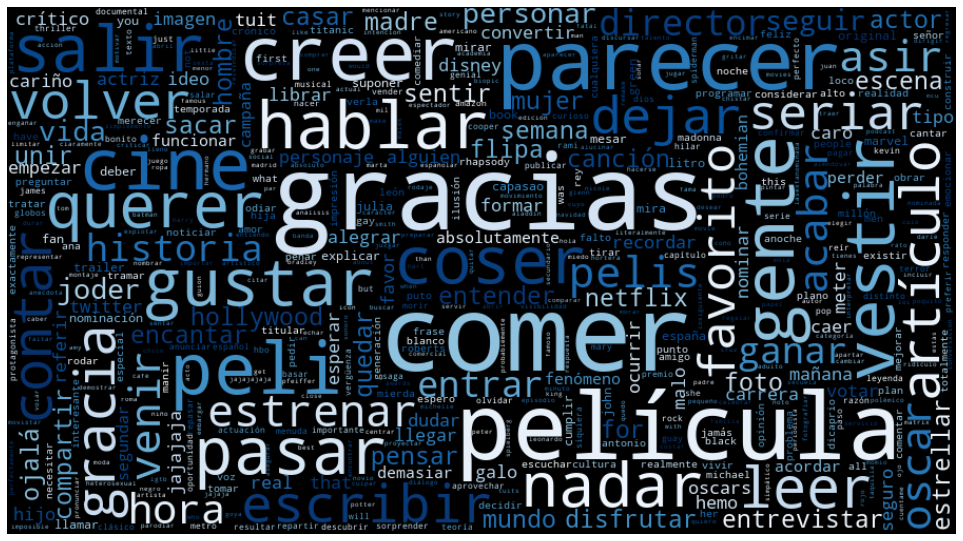

In [18]:
all_words = []
for line in tweets_user['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3).fit(tweets_user['text'].values)

In [20]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_user['text'].values)
#tfidf_matrix = tfidf_vectorizer.transform(tweets_colega['text'].values)

print(tfidf_matrix.shape)

CPU times: user 28 s, sys: 104 ms, total: 28.1 s
Wall time: 28.2 s
(3226, 1273)


In [21]:
terms = tfidf_vectorizer.get_feature_names()

In [22]:
array_matrix = tfidf_matrix.toarray()

In [23]:
first_vector_tfidfvectorizer=tfidf_matrix[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

tfidf
play       0.810835
vida       0.585275
abandonar  0.000000
oficial    0.000000
one        0.000000

vocab = tfidf_vectorizer.vocabulary_

dist = 1 - cosine_similarity(tfidf_matrix)
dist

In [24]:
umap = UMAP(n_components=2, n_neighbors=5, random_state=42).fit(tfidf_matrix)
embedding = umap.fit_transform(tfidf_matrix)

# tweets from your colega
#embedding_colega = umap.transform(tfidf_matrix_colega)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../../../../../miniconda3/envs/py366/lib/python3.6/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/miniconda3/envs/py366/lib/python3.6/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../../../../../miniconda3/envs/py366/lib/python3.6/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/miniconda3/envs/py366/lib/python3.6/site-packages/numba/compiler.py

In [25]:
umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

In [26]:
umap_df.head()

emb_1     emb_2
0  -6.348885  2.942502
1 -12.595200  5.795689
2 -13.831307  7.041585
3 -11.275749  1.635675
4 -14.194947  3.936921

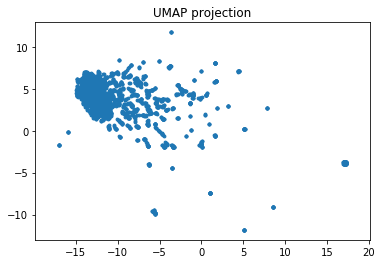

In [27]:
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=12);

In [28]:
hdbscan = HDBSCAN(min_cluster_size=20, prediction_data=True)
clustering = hdbscan.fit_predict(embedding)
np.unique(clustering)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19])

In [29]:
labels = hdbscan.labels_

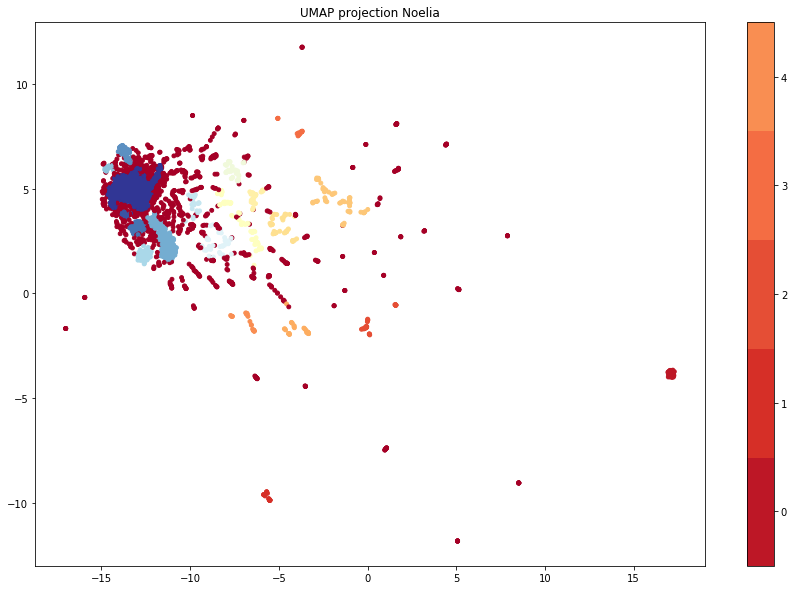

In [30]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =labels, cmap='RdYlBu', s=15)
plt.colorbar(boundaries=np.arange(6)-0.5).set_ticks(np.arange(5))
plt.title('UMAP projection Noelia', fontsize=12);

In [31]:
tweets = {'tweet': tweets_user['text'].values, "words": tweets_user['tokenized'].values, 'cluster': labels, "mention": tweets_user['mention'].values, "RT": tweets_user['RT'].values, "date": tweets_user['date'].values}
cluster_user = pd.DataFrame(tweets, columns = ['tweet', 'words', "cluster", "mention", "RT", "date"])

In [32]:
cluster_user[cluster_user['cluster']==0].head()

tweet             words  cluster          mention  \
10      @pablerasng Gracias!! 😘         [gracias]        0       pablerasng   
13   @Laura_locuenta Gracias :)         [gracias]        0   Laura_locuenta   
25       @MarioCS1985 Gracias 🙂         [gracias]        0      MarioCS1985   
26   @luciacab Gracias Lucía ☺️  [gracias, lucía]        0         luciacab   
37  @cristianreyesp2 Gracias :)         [gracias]        0  cristianreyesp2   

    RT        date  
10   0  2019-07-31  
13   0  2019-07-31  
25   0  2019-07-30  
26   0  2019-07-30  
37   0  2019-07-29

In [33]:
cluster_user = cluster_user.reset_index(drop=True)

In [34]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

abandonar  abc  abordar  about  abril  abrir  absolutamente  absoluto  \
0        0.0  0.0      0.0    0.0    0.0    0.0            0.0       0.0   
1        0.0  0.0      0.0    0.0    0.0    0.0            0.0       0.0   
2        0.0  0.0      0.0    0.0    0.0    0.0            0.0       0.0   
3        0.0  0.0      0.0    0.0    0.0    0.0            0.0       0.0   
4        0.0  0.0      0.0    0.0    0.0    0.0            0.0       0.0   

   abusar  acabar  ...  winning  with  woman  won  world  would  write  you  \
0     0.0     0.0  ...      0.0   0.0    0.0  0.0    0.0    0.0    0.0  0.0   
1     0.0     0.0  ...      0.0   0.0    0.0  0.0    0.0    0.0    0.0  0.0   
2     0.0     0.0  ...      0.0   0.0    0.0  0.0    0.0    0.0    0.0  0.0   
3     0.0     0.0  ...      0.0   0.0    0.0  0.0    0.0    0.0    0.0  0.0   
4     0.0     0.0  ...      0.0   0.0    0.0  0.0    0.0    0.0    0.0  0.0   

   your  zhivago  
0   0.0      0.0  
1   0.0      0.0  
2   0.0      0.0  
3   0.0      0.0  
4   0.0      0.0  

[5 rows x 1273 columns]

In [35]:
def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

In [36]:
top_words_cluster = get_df_from_cluster(1).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head(10)

compartir     14.266281
gracia         7.189972
stories        3.165657
importante     2.917156
leer           0.945582
artístico      0.718466
foto           0.642241
vario          0.628442
historia       0.565274
ganar          0.565274
dtype: float64

In [37]:
umap3d = UMAP(n_components=3, n_neighbors=5, random_state=42)
embedding3d = umap3d.fit_transform(tfidf_matrix)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


In [38]:
umap_df3d = pd.DataFrame(embedding3d, columns=[f'emb_{i+1}' for i in range(3)])

umap_df3d.head()

emb_1      emb_2      emb_3
0  4.569105  -8.681885  15.821652
1  5.354431  -9.592615  19.652760
2  3.649717  -8.974928  21.097137
3  5.795647  -7.925676  17.904346
4  5.927549 -10.153946  19.827065

In [39]:
import plotly.express as px
#iris = px.data.iris()
fig = px.scatter_3d(umap_df3d, x='emb_1', y='emb_2', z='emb_3',
              color='emb_3', size_max=20,
            opacity=0.7)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [40]:
tweets_friend = pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/levmauc_tweets.csv')

In [41]:
tweets_friend['RT'] = tweets_friend.text.apply(retweet)

In [42]:
tweets_friend['mention'] = tweets_friend.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [43]:
tweets_friend['hashtag'] = tweets_friend.text.str.extract(r'(\#\w+)', expand=False)

In [44]:
tweets_friend['hashtag'] = tweets_friend['hashtag'].fillna("")

In [45]:
tweets_friend['date'] = tweets_friend['created_at']

In [46]:
tweets_friend = tweets_friend.drop(columns=["created_at"], axis=1)

In [47]:
tweets_friend['tokenized'] = tweets_friend['text'].apply(spacy_tokenizer)

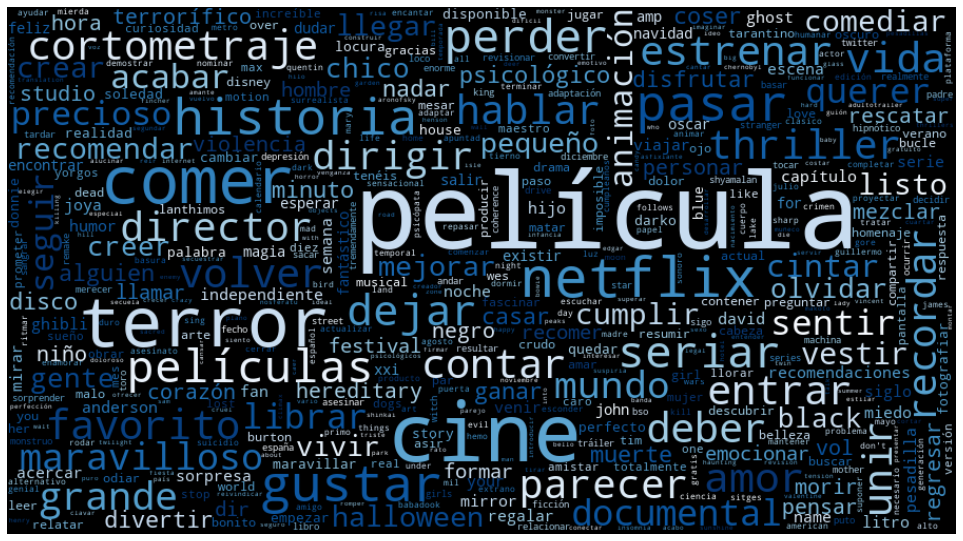

In [48]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

all_words = []
for line in tweets_friend['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
tfidf_vectorizer_friends = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)

%time tfidf_matrix_friends = tfidf_vectorizer_friends.fit_transform(tweets_friend['text'].values)


CPU times: user 15.9 s, sys: 62 ms, total: 16 s
Wall time: 16 s


In [50]:
print(tfidf_matrix_friends.shape)

(1605, 1146)


In [51]:
array_matrix_friend = tfidf_matrix_friends.toarray()

In [52]:
first_vector_tfidfvectorizer_friend=tfidf_matrix_friends[0]
df_friend = pd.DataFrame(first_vector_tfidfvectorizer_friend.T.todense(), index=tfidf_vectorizer_friends.get_feature_names(), columns=["tfidf"])
df_friend.sort_values(by=["tfidf"],ascending=False).head()

tfidf
construir  0.630242
precioso   0.470143
pequeño    0.470143
pasar      0.400907
abandonar  0.000000

In [53]:
embedding_friend = umap.fit_transform(array_matrix_friend)

In [54]:
umap_df_friend = pd.DataFrame(embedding_friend, columns=[f'emb_{i+1}' for i in range(2)])
umap_df_friend.head()


emb_1     emb_2
0  0.792052  2.570110
1  0.236964  2.073370
2  0.659039  2.548321
3 -2.749965 -0.454385
4  0.049519  0.280257

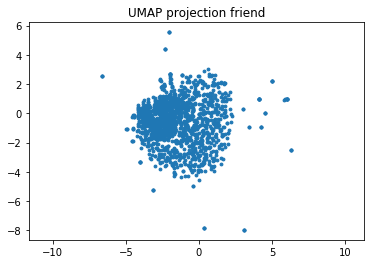

In [55]:
plt.scatter(umap_df_friend['emb_1'], umap_df_friend['emb_2'], cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection friend', fontsize=12);


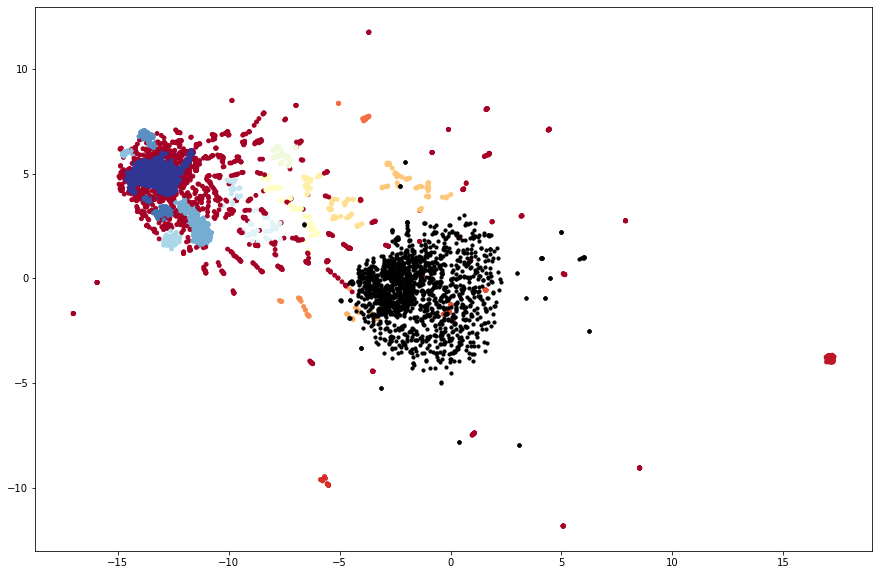

In [56]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =labels, cmap='RdYlBu', s=15)
plt.scatter(umap_df_friend['emb_1'],umap_df_friend['emb_2'], c='k', s=10)

In [80]:
hdbscan

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_method='eom',
        core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=20, min_samples=None, p=None,
        prediction_data=True)

In [98]:
#hdbscan = HDBSCAN(min_cluster_size=20, prediction_data=True)
#clustering = hdbscan.fit_predict(embedding)
#np.unique(clustering)

In [ ]:
data = np.load('clusterable_data.npy')
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, prediction_data=True).fit(data) 

pal = sns.color_palette('deep', 8)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_,
plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds);

In [140]:
clusterer = HDBSCAN(min_cluster_size=15, prediction_data=True).fit(embedding)

In [159]:
umap_df_friend = pd.DataFrame(embedding_friend, columns=[f'emb_{i+1}' for i in range(2)])

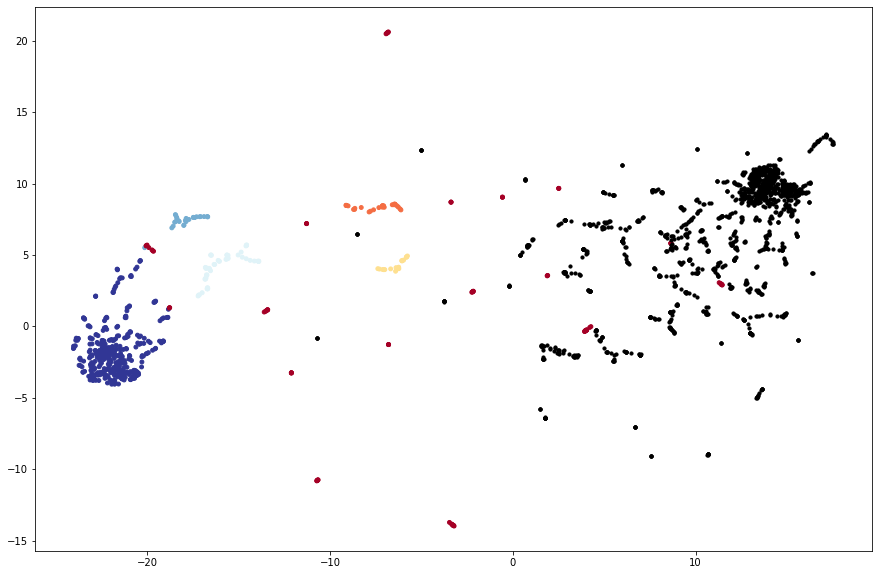

In [165]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =labels, cmap='RdYlBu', s=15)
plt.scatter(umap_df_friend['emb_1'],umap_df_friend['emb_2'], c='k', s=10)

In [58]:
tweets_friend_2= pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/Lionel10ok_tweets.csv')

In [59]:
tweets_friend_2['RT'] = tweets_friend_2.text.apply(retweet)

In [60]:
tweets_friend_2['mention'] = tweets_friend_2.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [61]:
tweets_friend_2['hashtag'] = tweets_friend_2.text.str.extract(r'(\#\w+)', expand=False)

In [62]:
tweets_friend_2['hashtag'] = tweets_friend_2['hashtag'].fillna("")

In [63]:
tweets_friend_2['date'] = tweets_friend_2['created_at']

In [64]:
tweets_friend_2 = tweets_friend_2.drop(columns=["created_at"], axis=1)

In [65]:
tweets_friend_2['tokenized'] = tweets_friend_2['text'].apply(spacy_tokenizer)

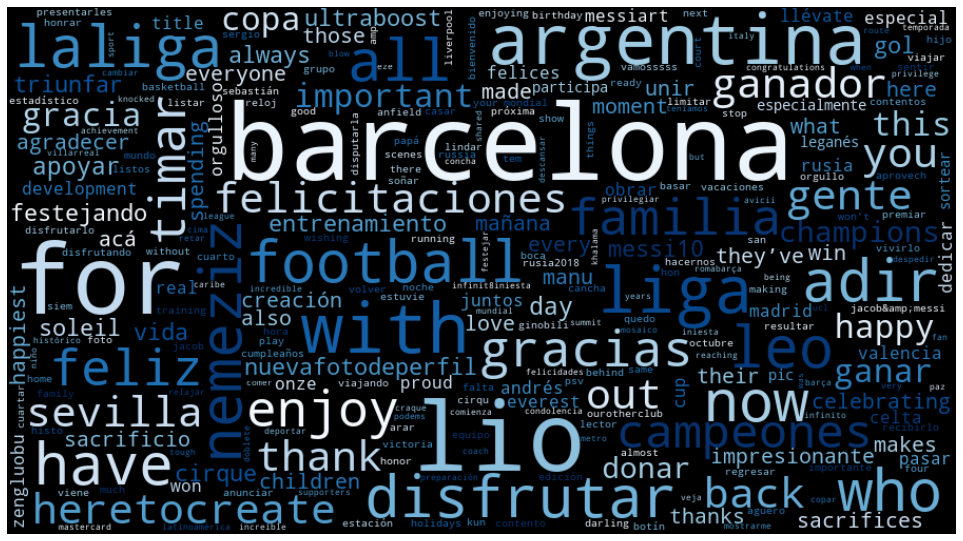

In [66]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

all_words = []
for line in tweets_friend_2['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [67]:
#tfidf_vectorizer_friends_2 = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)
%time tfidf_matrix_friends_2 = tfidf_vectorizer.fit_transform(tweets_friend_2['text'].values)

CPU times: user 987 ms, sys: 6.96 ms, total: 994 ms
Wall time: 994 ms


In [68]:
print(tfidf_matrix_friends_2.shape)

(136, 36)


In [69]:
array_matrix_friend_2 = tfidf_matrix_friends_2.toarray()

In [73]:
first_vector_tfidfvectorizer_friend_2=tfidf_matrix_friends_2[0]
df_friend_2 = pd.DataFrame(first_vector_tfidfvectorizer_friend_2.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df_friend_2.sort_values(by=["tfidf"],ascending=False).head()

tfidf
adir      0.0
all       0.0
gracia    0.0
happy     0.0
have      0.0

In [74]:
umap = UMAP(n_components=2, n_neighbors=5, random_state=42).fit(tfidf_matrix)
embedding = umap.fit_transform(tfidf_matrix)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



In [75]:
embedding_friend_2 = umap.fit_transform(array_matrix_friend_2)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



In [76]:
umap_df_friend_2 = pd.DataFrame(embedding_friend_2, columns=[f'emb_{i+1}' for i in range(2)])
umap_df_friend_2.head()

emb_1      emb_2
0  26.704685  11.995872
1  26.334183  12.903893
2  25.142656  12.374755
3  25.691795  12.422884
4  26.100590  13.995445

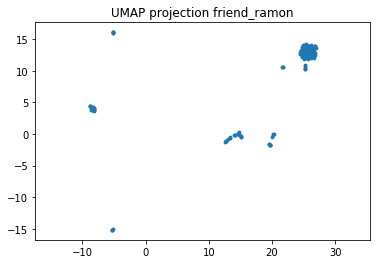

In [77]:
plt.scatter(umap_df_friend_2['emb_1'], umap_df_friend_2['emb_2'], cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection friend_ramon', fontsize=12);


In [83]:
tweets_friend_3= pd.read_csv('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/IkerCasillas_tweets.csv')

In [84]:
tweets_friend_3['RT'] = tweets_friend_3.text.apply(retweet)

In [85]:
tweets_friend_3['mention'] = tweets_friend_3.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

In [86]:
tweets_friend_3['hashtag'] = tweets_friend_3.text.str.extract(r'(\#\w+)', expand=False)

In [87]:
tweets_friend_3['hashtag'] = tweets_friend_3['hashtag'].fillna("")

In [88]:
tweets_friend_3['date'] = tweets_friend_3['created_at']

In [89]:
tweets_friend_3 = tweets_friend_3.drop(columns=["created_at"], axis=1)

In [90]:
tweets_friend_3['tokenized'] = tweets_friend_3['text'].apply(spacy_tokenizer)

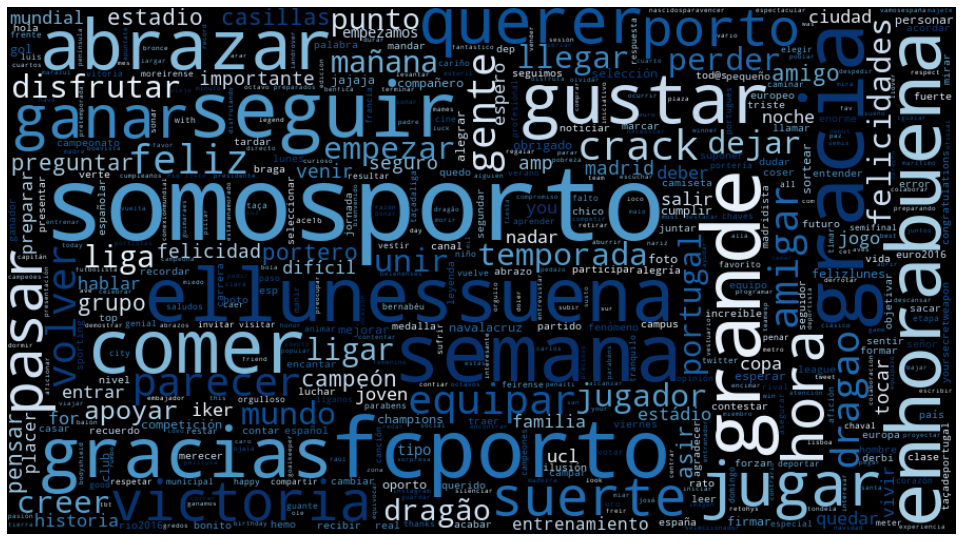

In [91]:
num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

all_words = []
for line in tweets_friend_3['tokenized']: 
    all_words.extend(line)
    
wordfreq = Counter(all_words)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [92]:
#tfidf_vectorizer_friends_2 = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)
%time tfidf_matrix_friends_3 = tfidf_vectorizer.fit_transform(tweets_friend_3['text'].values)

CPU times: user 28.7 s, sys: 87.1 ms, total: 28.8 s
Wall time: 28.8 s


In [93]:
print(tfidf_matrix_friends_3.shape)

(3211, 1000)


In [94]:
array_matrix_friend_3 = tfidf_matrix_friends_3.toarray()

In [95]:
first_vector_tfidfvectorizer_friend_3=tfidf_matrix_friends_3[0]
df_friend_3 = pd.DataFrame(first_vector_tfidfvectorizer_friend_3.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df_friend_3.sort_values(by=["tfidf"],ascending=False).head()

tfidf
enhorabuena  0.669512
demostrar    0.527872
gente        0.382284
volver       0.356319
pasar        0.000000

In [96]:
embedding_friend_3 = umap.fit_transform(array_matrix_friend_3)

/miniconda3/envs/py366/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 4 separate connected components using meta-embedding (experimental)



In [101]:
umap_df_friend_3 = pd.DataFrame(embedding_friend_3, columns=[f'emb_{i+1}' for i in range(2)])
umap_df_friend_3.head()

emb_1     emb_2
0  11.131216  3.118492
1  32.299789  1.171667
2  38.202251 -3.310635
3  37.611595 -2.726602
4  38.701569 -2.511197

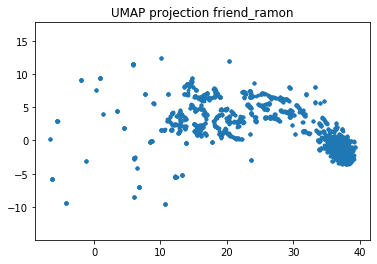

In [102]:
plt.scatter(umap_df_friend_3['emb_1'], umap_df_friend_3['emb_2'], cmap='Spectral', s=8)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection friend_ramon', fontsize=12);


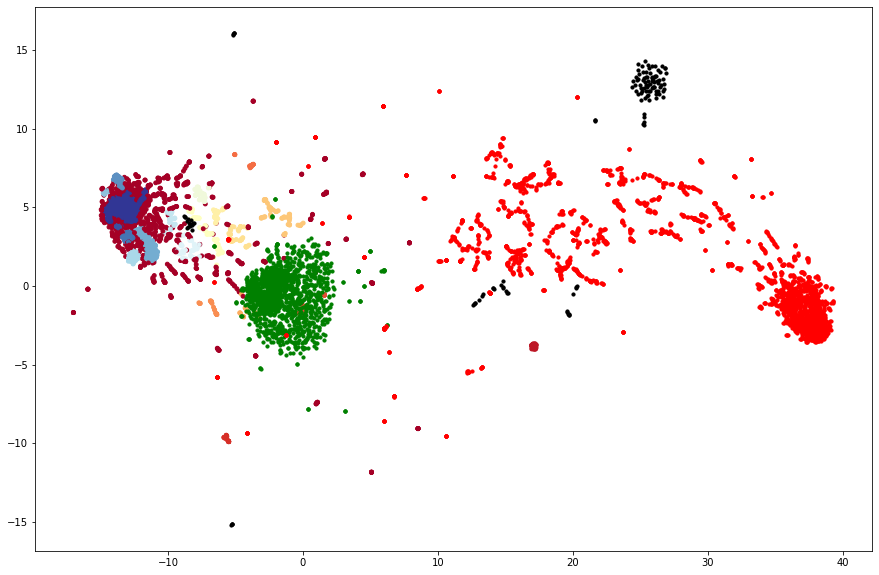

In [103]:
fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =labels, cmap='RdYlBu', s=15)
plt.scatter(umap_df_friend_2['emb_1'],umap_df_friend_2['emb_2'], c='k', s=10)
plt.scatter(umap_df_friend['emb_1'],umap_df_friend['emb_2'], c='g', s=10)
plt.scatter(umap_df_friend_3['emb_1'],umap_df_friend_3['emb_2'], c='r', s=10)

In [213]:
tweets_ramon = {'tweet': tweets_friend_2['text'].values, "words": tweets_friend_2['tokenized'].values, "mention": tweets_friend_2['mention'].values, "RT": tweets_friend_2['RT'].values, "date": tweets_friend_2['date'].values}
cluster_ramon = pd.DataFrame(tweets_ramon, columns = ['tweet', 'words', "cluster", "mention", "RT", "date"])

In [220]:
cluster_ramon[['words']].head()

words
0  [die, that, may, meaning, life, but, language,...
1  [madrid, montar, estructurar, ilícito, permane...
2  [toni, morrison, nobel, laureate, who, transfi...
3  [eta, responder, estrategia, utilizan, dolor, ...
4                                          [igualar]

In [ ]:
plt.scatter(*test_points.T, c='k', s=50)

In [146]:
test_labels, strengths = HDBSCAN.approximate_predict(clusterer, embedding_friend)
test_labels

AttributeError: type object 'HDBSCAN' has no attribute 'approximate_predict'

In [ ]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)
test_labels

In [158]:
clusterer.generate_prediction_data()

In [155]:
embedding_friend.shape

(1569, 2)

In [143]:
test_labels, strengths = clusterer.approximate_predict(clusterer, test_points)
test_labels

AttributeError: 'HDBSCAN' object has no attribute 'approximate_predict'

In [116]:
model = hdbscan.HDBSCAN(prediction_data=True).fit(embedding)
labels, membership_strengths = hdbscan.approximate_predict(model, embedding_friend)

AttributeError: 'HDBSCAN' object has no attribute 'HDBSCAN'

In [110]:
hdbscan = HDBSCAN(prediction_data=True)
#test_labels, strengths = hdbscan.approximate_predict(clusterer, embedding_friend)

In [104]:
hdbscan.approximate_predict()

AttributeError: 'HDBSCAN' object has no attribute 'approximate_predict'

In [115]:
hdbscan.approximate_predict(hdbscan_, embedding_friend)

AttributeError: 'HDBSCAN' object has no attribute 'approximate_predict'

In [106]:
test_labels, strengths = hdbscan.approximate_predict(hdbscan, embedding_friend)

AttributeError: 'HDBSCAN' object has no attribute 'approximate_predict'

In [69]:
clustering_friend = hdbscan.prediction.approximate_predict(embedding_friend)
np.unique(clustering_friend)

AttributeError: 'HDBSCAN' object has no attribute 'prediction'

In [50]:
cluster_user.to_csv("../output/cluster_user.csv")